In [19]:
#import de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [20]:
#carga de datos
df = pd.read_csv('../datos_simulados/datos_final.csv')
df.head()

,Clase,Pieza,Superficie_1,Superficie_2,Tamaño_cavidad_mm,Estado_cavidad,Tecnica,Tipo_resina,Índice_contracción_%,Peso_resina_inicial_mg,Peso_sobrante_mg,Margen_cavo_mm,Ajuste_margen
0,VI,6,Incisal,NaN,2.27,Limpia,Estratificación,Compuesta,1.79,68.41,7.88,1.74,Sobreobturado
1,I,31,Oclusal,NaN,4.68,Con tejido remanente,Bulk,Compuesta,3.24,84.91,15.84,1.37,Subobturado
2,I,16,Lingual,NaN,2.44,Limpia,Estratificación,Bulk,1.55,50.25,7.10,0.86,Sobreobturado
3,V,17,Lingual,NaN,1.19,Con tejido remanente,Bulk,Con fibra de vidrio,2.22,117.59,6.72,1.47,Subobturado
4,V,24,Lingual,NaN,3.12,Limpia,Bulk,Con fibra de vidrio,3.59,65.80,12.40,1.51,Sobreobturado


In [21]:
# Variables categóricas
columnas_binarias = ['Estado_cavidad']  # limpia, remanente
columnas_onehot = [
    'Superficie_1',       # Bucal, Lingual, etc.
    'Clase',              # I, II, III, IV, V, VI.
    'Tecnica',            # Bulk, Estratificación
    'Tipo_resina',        # Compuesta, Fluida, etc.
    'Ajuste_margen',      # Sobreobt, Subobt, Equiobt
    'Superficie_2'        # Mesial, Distal, ninguna
]

# Rellenar valores nulos en Superficie_2 con 'ninguna'
df.fillna({'Superficie_2': 'ninguna'}, inplace=True)

# Binarizar 'Estado_cavidad'
df['Estado_cavidad'] = df['Estado_cavidad'].map({
    'Limpia': 0,
    'Con tejido remanente': 1
})


# Aplicar OneHotEncoder
df_codificado = pd.get_dummies(df, columns=columnas_onehot, dtype=int)

# Mostrar los primeros registros codificados
df_codificado.head()


,Pieza,Tamaño_cavidad_mm,Estado_cavidad,Índice_contracción_%,Peso_resina_inicial_mg,Peso_sobrante_mg,Margen_cavo_mm,Superficie_1_Bucal,Superficie_1_Distal,Superficie_1_Incisal,...,Tipo_resina_Bulk,Tipo_resina_Compuesta,Tipo_resina_Con fibra de vidrio,Tipo_resina_Fluida,Ajuste_margen_Equiobturado,Ajuste_margen_Sobreobturado,Ajuste_margen_Subobturado,Superficie_2_Distal,Superficie_2_Mesial,Superficie_2_ninguna
0,6,2.27,0,1.79,68.41,7.88,1.74,0,0,1,...,0,1,0,0,0,1,0,0,0,1
1,31,4.68,1,3.24,84.91,15.84,1.37,0,0,0,...,0,1,0,0,0,0,1,0,0,1
2,16,2.44,0,1.55,50.25,7.10,0.86,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,17,1.19,1,2.22,117.59,6.72,1.47,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,24,3.12,0,3.59,65.80,12.40,1.51,0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [22]:
# Variable objetivo: cuánta resina se debe utilizar
#y = df_codificado['Peso_resina_inicial_mg']

# Variables de entrada: eliminamos columnas que no deben usarse para predecir
#X = df_codificado.drop(columns=['Peso_resina_inicial_mg', 'Peso_sobrante_mg'])
# Crear la nueva variable objetivo: resina realmente utilizada
df_codificado['Resina_utilizada'] = df_codificado['Peso_resina_inicial_mg'] - df_codificado['Peso_sobrante_mg']

# Definir variable objetivo
y = df_codificado['Resina_utilizada']

# Eliminar columnas que no deben usarse para predecir
X = df_codificado.drop(columns=['Peso_resina_inicial_mg', 'Peso_sobrante_mg', 'Resina_utilizada'])


In [23]:
# Dividir los datos en entrenamiento (75%) y prueba (25%)
# test_size=0.25 indica que el 25% de los datos será para prueba
# random_state=42 garantiza que la división siempre sea la misma (para reproducibilidad)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [25]:
# Realizar predicciones sobre los datos de prueba
y_pred = modelo.predict(X_test)

# Calcular el RMSE (raíz del error cuadrático medio)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular el R² (coeficiente de determinación)
r2 = r2_score(y_test, y_pred)

#métricas de evaluación
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 18.89
R²: 0.26


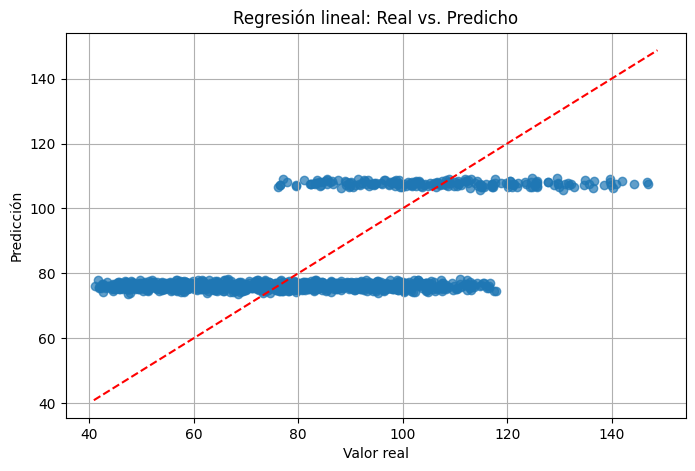

In [26]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Regresión lineal: Real vs. Predicho")
plt.grid(True)
plt.show()


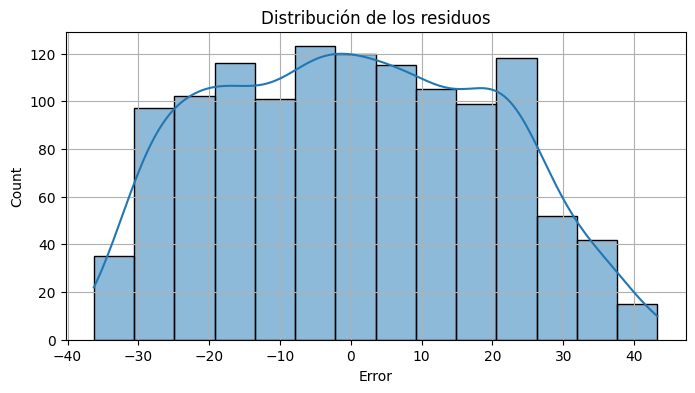

In [27]:
residuos = y_test - y_pred

plt.figure(figsize=(8,4))
sns.histplot(residuos, kde=True)
plt.title("Distribución de los residuos")
plt.xlabel("Error")
plt.grid(True)
plt.show()

In [28]:
# Predicción de resina ideal según el modelo
resina_predicha = modelo.predict(X_test)


In [29]:
# Error = valor real - valor predicho
error_resina = y_test - resina_predicha


In [30]:
# Ajuste: simular corrección en la clínica
resina_ajustada = y_test - error_resina  # equivalente a resina_predicha


In [31]:


rmse_ajuste = np.sqrt(mean_squared_error(y_test, resina_ajustada))
r2_ajuste = r2_score(y_test, resina_ajustada)

print(f"Ajuste simulado:")
print(f"RMSE: {rmse_ajuste:.2f}")
print(f"R²: {r2_ajuste:.2f}")


Ajuste simulado:
RMSE: 18.89
R²: 0.26
